# Supervised simple classifier test

This notebook is testing the "simple classifier" model on the prelabeled Rainfall data for OCaml. The model has two parts: a recurrent neural network that encodes the token sequence into a latent representation, and a logistic regressor that classifies the latents into a label.

Any individual language has relatively few labeled programs (on the order of 50), so our hypothesis is that the model should generalize poorly.

First, we set up the imports and dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
from autoplan.trainer import ClassifierTrainer
from autoplan.dataset import PrelabeledDataset
from autoplan.vis import plot_accuracy, plot_cm, plot_loss

from tqdm import tqdm_notebook as tqdm
import pandas as pd
import torch
import os

device = torch.device('cpu')
REPO_DIR = os.path.expanduser('~/Code/autoplan')

In [9]:
# T1 refers to the OCaml data
dataset_name = 'T1'
dataset = PrelabeledDataset.load(f'{REPO_DIR}/data/rainfall/{dataset_name}.pkl')

## Dataset

Each student program has a corresponding token sequence and provided label. An example is shown below.

In [16]:
print('Total number of programs: {}'.format(len(dataset.dataset)))
print('One example dataset entry:\n')
item = dataset.dataset[0]
print('SOURCE:')
print(item['source'])
print('TOKENS:')
print(item['program'])
print('LABEL')
print(item['labels'].item())

Total number of programs: 45
One example dataset entry:

SOURCE:
let rec rainfall (alof : float list) =
  (let rec sum_helper (alof : float list) (sum : float) (counter : float) =
     (match (alof, counter) with
      | ([], 0.) -> failwith "Empty list."
      | ((-999.)::_, 0.) -> failwith "Empty list."
      | ([], _) -> (sum, counter)
      | ((-999.)::_, _) -> (sum, counter)
      | (hd::tl, _) ->
          if hd >= 0.
          then sum_helper tl (sum +. hd) (counter +. 1.)
          else sum_helper tl sum counter : (float * float)) in
   match sum_helper alof 0. 0. with | (s, c) -> s /. c : float)

TOKENS:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  3,  0,  1, 10,  3,  4,  5,  6,
         7,  8,  3, 11,  5,  6,  8,  3, 12,  5,  6,  8,  9,  3, 13,  3,  4, 14,
        12,  8, 15, 16,  3, 17, 18, 14, 19,  8, 20, 21, 22, 16,  3,  3, 23, 24,
         8, 25, 26, 14, 19,  8, 20, 21, 22, 16,  3, 17, 18, 14, 26,  8, 20,  3,
        11, 14, 12,  8, 16,  3,  3, 23, 24,  8, 25, 26, 14,

## Model training

The student data is randomly split into a training and validation set, and the model goes through a standard supervised gradient descent training loop.

In [18]:
trainer = ClassifierTrainer(dataset, device=device, val_frac=0.3)
losses = []
train_eval = []
val_eval = []

In [33]:
for _ in tqdm(range(50)):
    losses.append(trainer.train_one_epoch())
    train, val = trainer.eval()
    train_eval.append(train)
    val_eval.append(val)

## Evaluation

The loss goes down smoothly and bottoms out, suggesting the network has learned as much as it can.

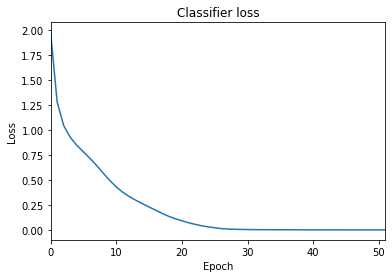

In [35]:
plot_loss(losses, title='Classifier loss')

The training set accuracy reaches 100%, confirming the previous hypothesis: the network has memorized the training set.

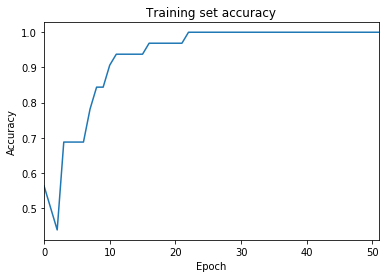

In [36]:
plot_accuracy(train_eval, title='Training set accuracy')

The validation set accuracy is not great, confirming our hypothesis that the network is not generalizing well.

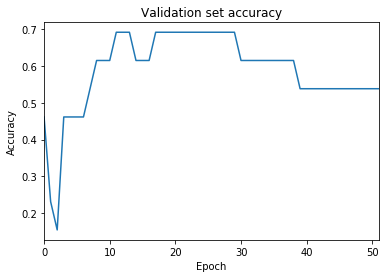

In [37]:
plot_accuracy(val_eval, title='Validation set accuracy')

The confusion matrix shows that the network is consistently classifying as one label (clean first).

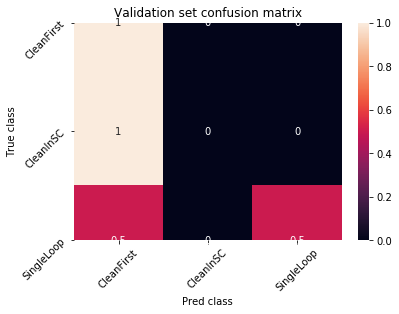

In [40]:
val_eval[-1].plot_cm('Validation set confusion matrix')